# Classifying Palmer Penguins



# Abstract

By using machine learning models, we can more easily classify the species of Palmer penguins given certain physical features—both quantitative and qualitative. Based on the exploration of data visualization, training and cross validation, it was concluded that a logistic regression model that was tested through cross validation using Culmen Depth (mm), Culmen Length (mm) and Island of origin (Biscoe, Dream or Torgersen) provided a 100% accurate classifier for future testing data.

To start the process, we need to implement the training data and our packages for data visualization.

In [19]:
import pandas as pd
import seaborn as sns
import numpy as np


train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


# Exploring Visualizations

In order to accurately predict the species of penguin, we need to determine the best subset of data and features to train on. To do this, we will look at some data visualization.

First, we need to prepare the data. Given the data, we will drop some columns that we will not be able to train on and focus on either quantitative data (like culmen length/depth) or one-hot encoded columns, like sex or island of origin.

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

X_train


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,51.1,16.5,225.0,5250.0,8.20660,-26.36863,True,False,False,True,False,True,False,True
271,35.9,16.6,190.0,3050.0,8.47781,-26.07821,False,False,True,True,True,False,True,False
272,39.5,17.8,188.0,3300.0,9.66523,-25.06020,False,True,False,True,False,True,True,False
273,36.7,19.3,193.0,3450.0,8.76651,-25.32426,False,False,True,True,False,True,True,False


To choose the best possible features for our model, it's helpful to visualize the dat.

Firstly, I want to find the one hot encoded feature which doesn't contain any numeric values. Below I'm using a box plot to visualize the the difference in the culmen depths between islands. 

<Axes: xlabel='Island', ylabel='Culmen Depth (mm)'>

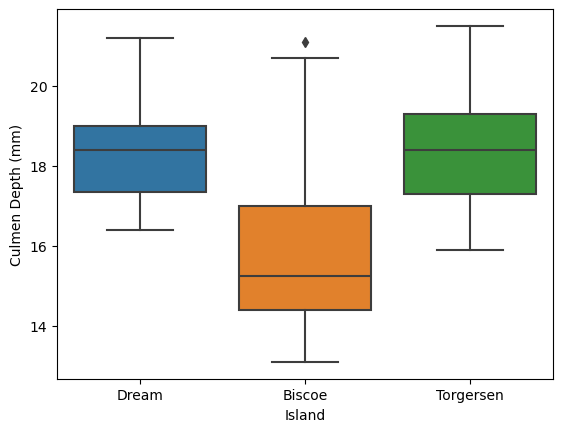

In [21]:
sns.boxplot(data=train, x="Island", y="Culmen Depth (mm)")

FIGURE 1: In the above figure, we can see that there is enough variance between the islands to ensure this feature could be viable. This is especially apparent on Biscoe island, which may be due to a very specific population of penguin on that island.

We can also see how this changes between the different species.

<Axes: xlabel='Island', ylabel='Culmen Depth (mm)'>

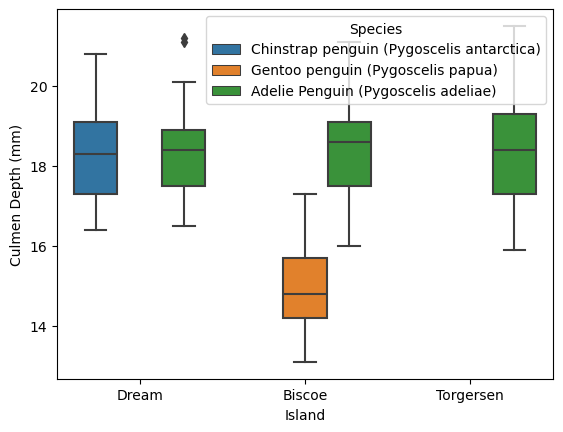

In [9]:
sns.boxplot(data=train, x="Island", y="Culmen Depth (mm)", hue="Species")

FIGURE 2: Here we can see the reason for the large difference in Biscoe island—when separating boxes by species. Biscoe island is the only one with the Gentoo penguin, which has a significantly smaller culmen depth. This visualization also tells us that island can be a good one-hot encoded feature and an indicator of the type of penguin.

We can also look at some other numerical features by comparing them to culmen depth.

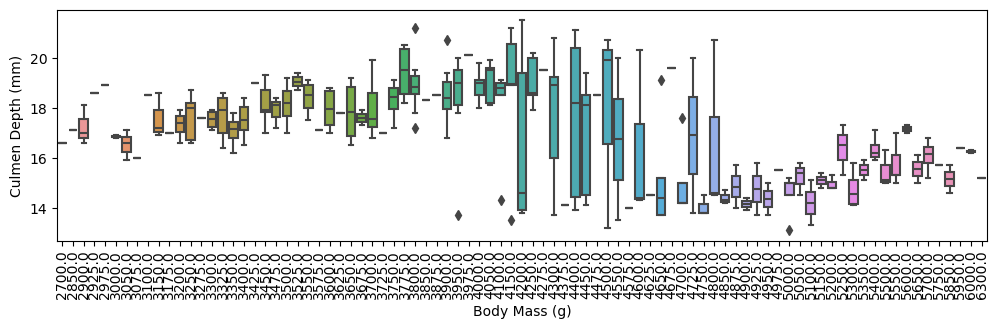

In [17]:
import matplotlib.pyplot as plt

ax = plt.subplots(figsize=(12, 3))
plot = sns.boxplot(train, x = "Body Mass (g)", y = "Culmen Depth (mm)", width=0.8)
plot.tick_params(axis='x', rotation=90)



FIGURE 3: As body mass increases, culmen depth increases for a certain range, but there seems to be a threshold where it drops, perhaps due to a unique body proportion of a species.

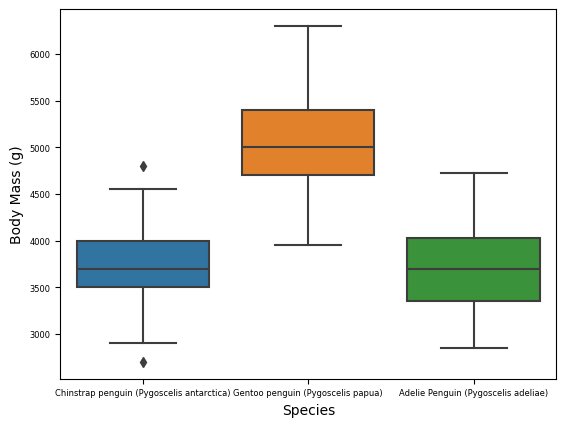

In [8]:
plot = sns.boxplot(data=train, x="Species", y="Body Mass (g)")
plot.tick_params(labelsize=6)


FIGURE 4: The Gentoo penguin has a larger mass, but in figure 2, it has a notably smaller culmen depth. Therefore, we see no discernable trend between body mass and culmen depth. With how variant Culmen depth is, it may be a good numeric feature. 

However, we also need to see if culmen depth itself could be used as a good numeric feature. Additionally, we need a second numerical feature to ensure the quality of the training. To do this we can remove the features with low variance.

We can select an 80% variance threshold and plug our cleaned up data frame

In [ ]:
from sklearn.feature_selection import VarianceThreshold
variance = VarianceThreshold(threshold=(.8 * (1 - .8)))

variance.fit_transform(X_train)

# Choosing Our Model

We can loop through all combinations of columns of possible features we want to use. As of now, I may want to use Island as my one-hot-encoded feature and Culmen Depth as a numerical feature, but we will iterate through all feature combinations using itertools.

I will test logistic regression, random forest classifier and a decision tree. For each model, I will keep track of the best score for the given feature combination.

However, before I determine the accuracy of the decision tree, I need to find the best max_depth parameter. To do this, I will use cross validation and an exhaustive search between two possible depth values. We will test depths 5-20 for this example with a 7 fold cross validation.

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


depths = []
max_score = 0
best_depth = 0
for i in range(5,20):
    classifier = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=7, n_jobs=4)
    if scores.mean() > max_score: 
        max_score = scores.mean()
        best_depth = i
    depths.append((i,scores.mean()))


print(depths)
print(max_score)
print(best_depth)

[(5, 0.960960960960961), (6, 0.9649292149292149), (7, 0.9649292149292149), (8, 0.961068211068211), (9, 0.9649292149292149), (10, 0.965036465036465), (11, 0.961068211068211), (12, 0.9649292149292149), (13, 0.965036465036465), (14, 0.9688974688974689), (15, 0.9649292149292149), (16, 0.960960960960961), (17, 0.961068211068211), (18, 0.961068211068211), (19, 0.9688974688974689)]
0.9688974688974689
14


From the search, it seems that a max depth of 7 gives the best average score when cross validating. Now we can search through each feature combination and train our three models:

In [22]:
from itertools import combinations

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


#keep track of the best score for each
logreg_score = 0
logreg_features = []

decision_score = 0
decision_features = []

forest_score = 0
forest_features = []


# these are not actually all the columns: you'll 
# need to add any of the other ones you want to search for
all_qual_cols = ["Island", "Clutch Completion"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)']

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    
    #logistic regression
    LR = LogisticRegression()
    LR.fit(X_train[cols], y_train)
    temp_score = LR.score(X_train[cols], y_train)
    if temp_score > logreg_score:
      logreg_score = temp_score
      logreg_features = cols

    #RANDOM FOREST
    RF = RandomForestClassifier()
    RF.fit(X_train[cols], y_train)
    temp_score = RF.score(X_train[cols], y_train)
    if temp_score > forest_score:
      forest_score = temp_score
      forest_features = cols

    #DECISION TREE
    DT = DecisionTreeClassifier(max_depth=7)
    DT.fit(X_train[cols], y_train)
    temp_score = DT.score(X_train[cols], y_train)
    if temp_score > decision_score:
      decision_score = temp_score
      decision_features = cols
    

print("Logical regression score:", logreg_score)
print("Logical regression best feautes", logreg_features)
print()
print("Random forest score: ", forest_score)
print("Random forest best features", forest_features)
print()
print("Decision tree score: ", decision_score)
print("Decision tree best features", decision_features)

Logical regression score: 0.99609375
Logical regression best feautes ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']

Random forest score:  1.0
Random forest best features ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']

Decision tree score:  1.0
Decision tree best features ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']


From the initial classifications, the random forest and decision trees seem to give 100% testing accuracy and all three models agree that island, culmen length and culmen depth are the best options for features. However, we need to do some cross validation to prevent over-fitting.

In [29]:
cv_lr = cross_val_score(LR, X_train, y_train, cv=7).mean()
cv_rf = cross_val_score(RF, X_train, y_train, cv=7).mean()
cv_dt = cross_val_score(DT, X_train, y_train, cv=7).mean()

print("logistic regression: ", cv_lr)
print("Random Forest: ", cv_rf)
print("Decision Tree: ", cv_dt)


logistic regression:  1.0
Random Forest:  0.9882024882024882
Decision Tree:  0.9649292149292149


The result of our cross validation reveals that logistic regression has a 100% accuracy. We now know we can create a reliable logistic regression model with our three features: Culmen Depth, Culmen Length and Island.

# Testing

We will now test our model with a new dataset, which produces a perfect prediction for the testing data.

In [26]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

columns = ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']

X_test, y_test = prepare_data(test)
LR.fit(X_train[columns], y_train)
LR.score(X_test[columns], y_test)

1.0

# Plotting Decision Regions

Now that we have our accurate model and test data, we want to plot our decision regions.

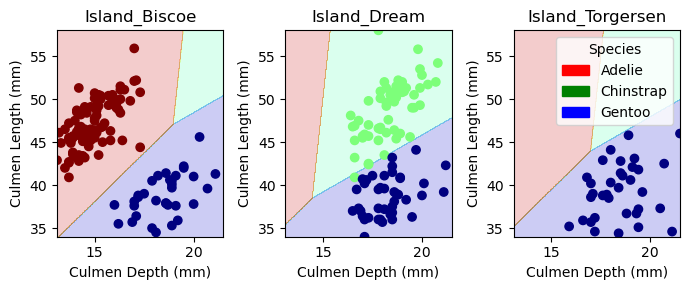

In [27]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

plot_regions(LR, X_train[columns], y_train)

Plotting our decision regions provides a good visualization of our model and the reasoning behind its decisions. For each island, there is enough distinction between our quantitative features to provide accurate classification.

# Confusion Matrix

Another way to get a good indication of our model and its accuracy is to create a confusion matrix:

In [28]:
from sklearn.metrics import confusion_matrix

prediction = LR.predict(X_test[columns])

confusion_matrix = confusion_matrix(y_test, prediction)

print(confusion_matrix)



[[31  0  0]
 [ 0 11  0]
 [ 0  0 26]]


The result of our confusion matrix shows only values on the diagonal axis, revealing the models accuracy.

# Discussion

Based on my exploration of various models and features, I concluded that a logistic regression model trained with high variance features Culmen Depth, Culmen Length and one qualitative feature, Island, produces a 100% accurate model for classifying Palmer penguins. One thing that I learned from this exploration is the importance of steps like cross validation. Although on the surface, some models— for example our decision tree—we're more accurate, cross validation reveals they were less so due to over-fitting and the nature of the dataset. I also learned the importance of data visualization in finding correct features and discerning trends in the data. Also revealing the decision regions of the model helps me understand why certain features work. There are many steps for determining the right classification model, and many of these steps can lead to interesting and surprising discoveries.
